The center of the enclosing circle is at coordinates: (1133, 1133)
X (mm)	Y (mm)	d (mm)	2θ (degrees)	Intensity
[[0.00000000e+00 0.00000000e+00 2.40310255e+02 6.74064024e+01
  6.37500000e+01]
 [0.00000000e+00 1.49977944e-01 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [0.00000000e+00 2.99955889e-01 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 ...
 [3.39850022e+02 3.39550066e+02 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 [3.39850022e+02 3.39700044e+02 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [3.39850022e+02 3.39850022e+02 2.40310255e+02 6.74064024e+01
  6.37500000e+01]]


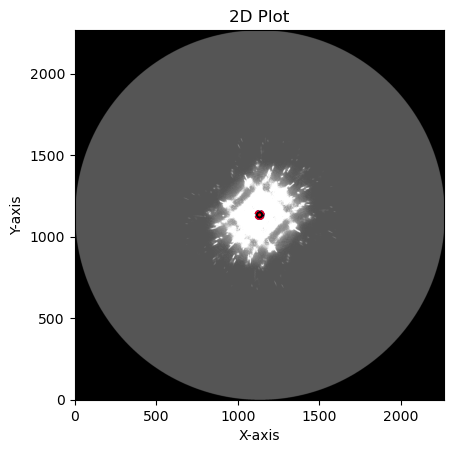

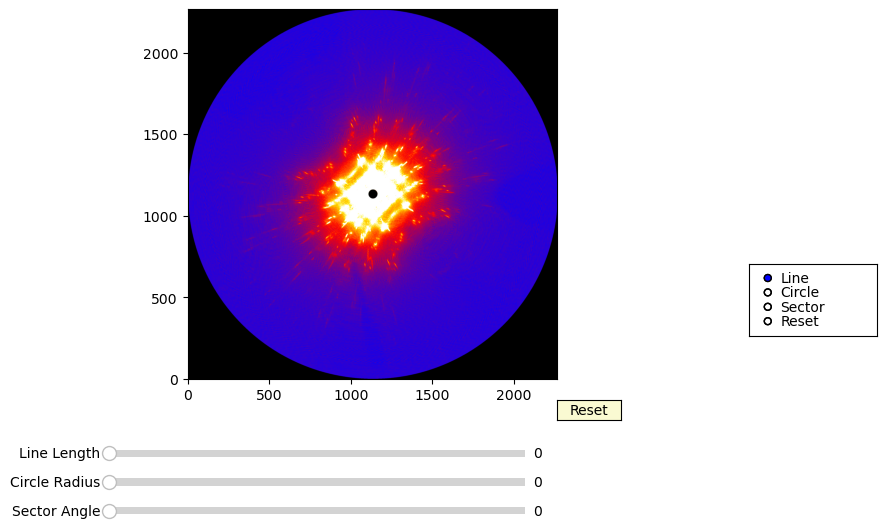

In [5]:
## Image Plate Diffraction System ##

## Image Analysis Interactive Selection (Version 1.3) ##

## Empa, Center for X-ray Analytics, D.Sapalidis, St. Gallen, Switzerland, 22.12.2023 ##


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Wedge
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.patches as patches
import cv2
from PIL import Image
import mplcursors


class ImageClicker:
    def __init__(self, image_path, outer_radius_mm):
        self.image = np.array(Image.open(image_path))
        self.grayscale_image = np.mean(self.image, axis=2)
        self.fig, self.ax = plt.subplots()
        self.im = self.ax.imshow(self.grayscale_image, cmap='gray', origin='lower')
        self.coords = []

        self.ax.set_title('2D Plot')
        self.ax.set_xlabel('X-axis')
        self.ax.set_ylabel('Y-axis')

        self.outer_radius_mm = outer_radius_mm

        # Find the enclosing circle around points with minimum intensity
        self.center, radius = self.find_center_and_enclosing_circle()
        print(f'The center of the enclosing circle is at coordinates: ({self.center[0]}, {self.center[1]})')

        # Display the center and circles on the plot
        self.draw_circle(self.center[0], self.center[1], radius)

        # Draw the red disk on the plot
        red_disk_patch = patches.Circle((self.center[0], self.center[1]), radius, color='red', fill=False, linestyle='dashed')
        self.ax.add_patch(red_disk_patch)

    def find_center_and_enclosing_circle(self):
        # Define the region of interest (ROI)
        x_max, y_max = self.grayscale_image.shape
        roi_x_start, roi_x_end = x_max // 4, int(x_max / 1.5)
        roi_y_start, roi_y_end = y_max // 4, int(y_max / 1.5)

        # Extract the ROI from the grayscale image
        roi = self.grayscale_image[roi_x_start:roi_x_end, roi_y_start:roi_y_end]

        # Find the coordinates of points with minimum intensity in the ROI
        min_intensity_coords = np.argwhere(roi == np.min(roi))

        # Shift the coordinates back to the original image coordinates
        min_intensity_coords[:, 0] += roi_x_start
        min_intensity_coords[:, 1] += roi_y_start

        # Find the enclosing circle
        _, radius = cv2.minEnclosingCircle(min_intensity_coords.astype(np.float32))
        return tuple(map(int, min_intensity_coords.mean(axis=0))), int(radius)


    def draw_circle(self, center_x, center_y, radius):
        # Display the center and circle on the plot
        center_marker = plt.Circle((center_x, center_y), 5, color='red', fill=True)
        disk_patch = patches.Circle((center_x, center_y), radius, color='blue', fill=False, linestyle='dashed')

        self.ax.add_patch(center_marker)
        self.ax.add_patch(disk_patch)

class ImageProcessor:
    def __init__(self, clicker, wavelength, sample_detector_distance):
        self.clicker = clicker
        self.wavelength = wavelength
        self.sample_detector_distance = sample_detector_distance
        self.process_image()

    def process_image(self):
        mm_per_pixel_x = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[1]
        mm_per_pixel_y = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[0]

        mm_intensity_array = np.zeros_like(self.clicker.grayscale_image, dtype=float)
        mm_d_theta_intensity_array = []

        for x, row in enumerate(self.clicker.grayscale_image):
            for y, intensity in enumerate(row):
                radius = np.sqrt((x - self.clicker.center[0]) ** 2 + (y - self.clicker.center[1]) ** 2)
                mm_x = x * mm_per_pixel_x
                mm_y = y * mm_per_pixel_y

                # Calculate the distance from center d
                d = radius * (mm_per_pixel_x + mm_per_pixel_y)/2

                # Calculate the angle 2θ
                theta = np.degrees(np.arctan(d / self.sample_detector_distance))

                # Save the data
                mm_d_theta_intensity_array.append([mm_x, mm_y, d, theta, intensity])

        # Convert the list to a numpy array
        mm_d_theta_intensity_array = np.array(mm_d_theta_intensity_array)

        # Print the array
        print("X (mm)\tY (mm)\td (mm)\t2θ (degrees)\tIntensity")
        print(mm_d_theta_intensity_array)


class InteractiveIntegration:
    def __init__(self, image_path, center, outer_radius):
        self.image = np.array(Image.open(image_path))
        self.center = center
        self.outer_radius = outer_radius
        self.fig, self.ax = plt.subplots()

        # Display the image
        self.ax.imshow(self.image, cmap='gray', origin='lower')

        # Create the toolbox
        self.toolbox_ax = plt.axes([1.1, 0.2, 0.2, 0.15])
        self.toolbox = RadioButtons(self.toolbox_ax, ('Line', 'Circle', 'Sector', 'Reset'))

        # Create the sliders
        ax_line = plt.axes([0.1, -0.06, 0.65, 0.03], facecolor='lightgoldenrodyellow')
        ax_circle = plt.axes([0.1, -0.12, 0.65, 0.03], facecolor='lightgoldenrodyellow')
        ax_sector = plt.axes([0.1, -0.18, 0.65, 0.03], facecolor='lightgoldenrodyellow')

        line_slider = Slider(ax_line, 'Line Length', 0, 2 * self.outer_radius, valinit=0)
        circle_slider = Slider(ax_circle, 'Circle Radius', 0, self.outer_radius, valinit=0)
        sector_slider = Slider(ax_sector, 'Sector Angle', 0, 360, valinit=0)

        # Add the sliders to the list for possible use in other methods
        self.sliders = [line_slider, circle_slider, sector_slider]

        line_slider.on_changed(self.update_line)
        circle_slider.on_changed(self.update_circle)
        sector_slider.on_changed(self.update_sector)

        # Create the reset button
        reset_button_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
        self.reset_button = Button(reset_button_ax, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')
        self.reset_button.on_clicked(self.reset)

        # Create additional buttons for the toolbox
        self.toolbox.on_clicked(self.toolbox_callback)

        # Add the ability for interactive selection to control points
        mplcursors.cursor(hover=True).connect("add", self.show_info)

        # Initialize the current tool
        self.current_tool = None

    def toolbox_callback(self, label):
        # Call the corresponding method based on the user's selection
        if label == 'Line':
            self.start_line_tool()
        elif label == 'Circle':
            self.start_circle_tool()
        elif label == 'Sector':
            self.start_sector_tool()
        elif label == 'Reset':
            self.reset(None)

    def start_line_tool(self):
        # The user selected the tool for drawing a line
        self.current_tool = 'Line'

    def start_circle_tool(self):
        # The user selected the tool for drawing a circle
        self.current_tool = 'Circle'

    def start_sector_tool(self):
        # The user selected the tool for drawing a sector
        self.current_tool = 'Sector'

    def update_line(self, val):
        # Update the points of the line
        if self.current_tool == 'Line':
            self.line_points = [(0, 0), (val, 0)]
            self.ax_line.set_data([p[0] for p in self.line_points], [p[1] for p in self.line_points])
            plt.draw()

    def update_circle(self, val):
        # Update the circle
        if self.current_tool == 'Circle':
            self.circle_radius = val
            self.ax_circle.set_data([self.circle_center[0]], [self.circle_center[1]])
            plt.draw()

    def update_sector(self, val):
        # Update the sector
        if self.current_tool == 'Sector':
            self.sector_theta_range = (0, val)
            self.ax_sector.set_data([self.sector_center[0]], [self.sector_center[1]])
            plt.draw()

    def reset(self, event):
        # Reset the control points
        self.line_points = []
        self.circle_center = (0, 0)
        self.circle_radius = 0
        self.sector_center = (0, 0)
        self.sector_radius = 0
        self.sector_theta_range = (0, 90)

        # Reset the sliders
        for slider in self.sliders:
            slider.reset()

        # Reset the plots
        self.ax_line.set_data([], [])
        self.ax_circle.set_data([], [])
        self.ax_sector.set_data([], [])

        plt.draw()

    def show_info(self, sel):
        # Show the coordinates and intensity upon mouse selection
        sel.annotation.set_text(f'Coords: {sel.target[0]:.2f}, {sel.target[1]:.2f}\nIntensity: {self.get_intensity(sel.target)}')

    def get_intensity(self, point):
        # Calculate the intensity from the image at the selected point
        x, y = point
        intensity = self.image[int(y), int(x)]
        return intensity


if __name__ == "__main__":

    # Set the characteristics of the clicker and the image
    main_image_path = 'C:/Users/Dimitris/Desktop/IPDS Images Results/DCSQI_annealed_40mm_240min_om0_ph10rpm_201223.tif'
    outer_radius_mm = 170
    wavelength = 0.71  # in Ångströms
    sample_detector_distance = 100  # in mm

    clicker = ImageClicker(main_image_path, outer_radius_mm)
    processor = ImageProcessor(clicker, wavelength, sample_detector_distance)
    integration = InteractiveIntegration(main_image_path, clicker.center, outer_radius_mm)
plt.show()
